In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import seaborn as sns

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import read_homer_gene_exp, import_homer_diffgene, pull_comparisons_get_diff
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano, plot_exp_rpkm, gene_list_bar_plot

In [2]:
workingDirectory = '/home/h1bennet/strains_rna/results/A10_Manuscript_Figures_AllLiverCells//'
dataDirectory = '/home/h1bennet/strains_rna/results/K00_Strains_Control_Kupffer_RNA/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


In [28]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

To do this analysis we will pull from the differential analysis performed by Ty at the following location:  

     /home/ttroutman/strainsKupffer/rnaKupfferNASH/
 

# Import differential gene files for examination and plotting

## Write differential genes to list for metascape

In [4]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [5]:
strains = ['aj', 'balb', 'c57']
log2fc = 1
padj = 0.05
diffpath = '/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/'

In [6]:
gene_list_dict ={}

In [7]:
for strain in strains:
    # initialize gene lists
    g_intersect = set()
    g_union = set()
    for i in glob.glob(diffpath+strain+'*control.vs.*control*.txt'):
        print(i)
        df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)

        # select differential genes
        # df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
        sig_genes = df.index[(df['padj'] < padj) & (df['log2FoldChange'] <= -log2fc)].to_list()
        
        # add to sets
        if len(g_union) == 0:
            g_union = set(sig_genes)
            g_intersect = set(sig_genes)
        else:
            g_union = g_union.union(sig_genes)
            g_intersect = g_intersect.intersection(sig_genes)
        
        # print('union set length:', print(len(g_union)))
        # print('intersection set length:', print(len(g_intersect)))
    
    # after getting union and intersection sets add to dict
    gene_list_dict[strain+'_union'] = list(g_union)
    gene_list_dict[strain+'_intersection'] = list(g_intersect)
        

/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj_control.vs.c57bl6j_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj_control.vs.balbcj_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/balbcj_control.vs.aj_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/balbcj_control.vs.c57bl6j_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/c57bl6j_control.vs.aj_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/c57bl6j_control.vs.balbcj_control.scatter.txt


Write gene lists separately

In [8]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/'+key+'_kupffer_genes_fc_'+str(log2fc)+'_pval_'+str(padj)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()


aj_union
227 genes
aj_intersection
33 genes
balb_union
230 genes
balb_intersection
45 genes
c57_union
236 genes
c57_intersection
69 genes


# Plot potential nichenet ligands

In [9]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures')

Read in raw expression values

In [10]:
tpm_mat = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaQuan/rawT.txt',
                      sep='\t', index_col=0)
tpm_mat = tpm_mat.loc[:, tpm_mat.columns.str.contains('control')]

# Plot potential nichenet receptors

Read in nichenet ligands

In [11]:
receptors = pd.read_csv(
    '/home/h1bennet/data/gene_lists/nichenet_receptors.csv')['to'].str.capitalize().tolist()
receptors[:5]

['Cxcr2', 'Cxcr1', 'Cxcr3', 'Cxcr4', 'Cxcr5']

## Look at union gene set

In [65]:
act = []
for key in gene_list_dict.keys():
    if 'union' in key:
        act.extend(gene_list_dict[key])

act = set(act)
# overlap with receptors
act_receptors = act.intersection(receptors)
print(len(act), 'activated genes')
print(len(act_receptors), 'activated receptors')

535 activated genes
37 activated receptors


In [71]:
# cluster targets
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

tmp_mat = np.log2(tpm_mat.loc[act_receptors]+1)
tmp_mat.columns = ['A/J', 'A/J', 'BALB/cJ', 'BALB/cJ', 'C57BL/6J', 'C57BL/6J']
d1 = dist.pdist(tmp_mat)
D1 = dist.squareform(d1)
Y1 = sch.linkage(D1, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
Z1 = sch.dendrogram(Y1, no_plot=True)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Remove the CWD from sys.path while we load stuff.


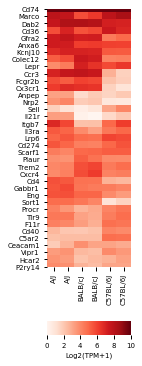

In [72]:
grid_kws = {"height_ratios": (.9, .05,), "hspace": .4}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(1.5,6))
sns.heatmap(
    tmp_mat.iloc[Z1['leaves'], :],
    cbar_kws={'orientation':'horizontal',
              'label': 'Log2(TPM+1)'},
    vmax=10,
    cbar_ax=cbar_ax,
    cmap='Reds',
    yticklabels=1,
    ax=ax)

plt.savefig('./fancy_figures/diff_expressed_receptors.pdf', bbox_inches='tight')


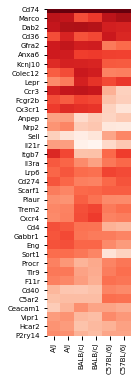

In [75]:
f, ax = plt.subplots(1, figsize=(1.5,6))
sns.heatmap(
    tmp_mat.iloc[Z1['leaves'], :],
#     cbar_kws={'orientation':'horizontal',
#               'label': 'Log2(TPM+1)'},
    vmax=10,
    cbar=False,
    # cbar_ax=cbar_ax,
    cmap='Reds',
    yticklabels=1,
    ax=ax)

plt.savefig('./fancy_figures/diff_expressed_receptors_no_cbar.pdf', bbox_inches='tight')


In [68]:
# cluster targets
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

tmp_mat = np.log2(tpm_mat.loc[act_receptors]+1)
tmp_mat.columns = ['A/J', 'A/J', 'BALB/cJ', 'BALB/cJ', 'C57BL/6J', 'C57BL/6J']

# z score
sd = np.std(tmp_mat, 1)
mean = np.mean(tmp_mat, 1)
z_frame = tmp_mat.subtract(mean, axis='rows').divide(sd, axis='rows')
z_frame.columns = z_frame.columns.str.split('_').str[0]

d1 = dist.pdist(z_frame)
D1 = dist.squareform(d1)
Y1 = sch.linkage(D1, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
Z1 = sch.dendrogram(Y1, no_plot=True)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:17: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


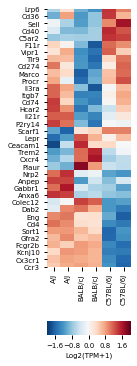

In [69]:
grid_kws = {"height_ratios": (.9, .05,), "hspace": .4}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(1.5,6))
sns.heatmap(
    z_frame.iloc[Z1['leaves'], :],
    cbar_kws={'orientation':'horizontal',
              'label': 'Log2(TPM+1)'},
    vmin=-2,
    vmax=2,
    cbar_ax=cbar_ax,
    cmap='RdBu_r',
    yticklabels=1,
    ax=ax)

plt.savefig('./fancy_figures/diff_expressed_receptors_zscore.pdf', bbox_inches='tight')